# Coping with real data
In lessons, we've discussed the problem of using observed data and the data processing pipeline elements needed to do that.  The key issue is how to tune the hyper-parameters for best accuracy for an observed data pipeline. This is largely a matter of balancing computation time with results. 

First, let's load the famous "iris" dataset from sklearn.

In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import svm, datasets
import matplotlib.pyplot as plt

iris = datasets.load_iris()  # iris.data and iris.target

And then let's set up a data processing pipeline for the data
from sklearn, as in Friday's lecture. 

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
pipe = Pipeline([['scale', StandardScaler()], ['classify', SVC()]])

The basic question here is how to train the hyper-parameters of the second step. There are several published methods. Let's try several of them and compare results! The key issue here is *how much computation time we will need to get the best results.* 

*Question 1*: Tune the hyper-parameters C and gamma for the above pipeline's SVC stage, using values of 1, 10, 100 for C and 0.01, 0.001, 0.0001 for gamma. Train a `GridSearchCV` called `grid`. We'll use this baseline to compare methods. 

In [4]:
from sklearn.model_selection import GridSearchCV
import time
start = time.process_time()
param_grid = {
    'classify__C': [1, 10, 100],
    'classify__gamma': [0.01, 0.001, 0.0001]
}

# Set up GridSearchCV with the pipeline and parameter grid
grid = GridSearchCV(pipe, param_grid, cv=5)  # 5x cross-validation

# Fit grid search to the iris dataset
grid.fit(iris.data, iris.target)
# END SOLUTION
# This printout is for my benefit
end = time.process_time()
print(end - start, "seconds computation time")
print(grid.best_params_)
print(grid.best_score_)

0.06230899999999995 seconds computation time
{'classify__C': 10, 'classify__gamma': 0.01}
0.9733333333333334


In [5]:
assert isinstance(grid, sklearn.model_selection._search.GridSearchCV)

In [6]:
assert grid.best_params_['classify__C'] == 10

In [7]:
assert grid.best_params_['classify__gamma'] == 0.01

*Question 2:* One problem with the above is the resolution of the search. However, trying more values is computationally expensive and this lab is only 1.25 hours long! Read https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html and run a halving grid search for optimal hyperparameters, where you allow `C` to range between 1 and 100 (use `np.arange`) and `gamma` to range between 0.001 and 0.1 in 0.001 increments.  Call your halving grid `hgrid`. What is the best parameter combination from this search? 

Hints: Run it multiple times and see how it varies. *Don't bother running this search without halving; you'll be here all day! There are 10,000 test cases.*

In [8]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
start = time.process_time()
# BEGIN SOLUTION
param_grid = {
    'classify__C': np.arange(1, 101, 1),
    'classify__gamma': np.arange(0.001, 0.101, 0.001)
}

# Set up HalvingGridSearchCV with the pipeline and parameter grid
hgrid = HalvingGridSearchCV(pipe, param_grid, cv=5, factor=2, min_resources='exhaust', scoring='accuracy')

# Fit the halving grid search to the iris dataset
hgrid.fit(iris.data, iris.target)

# END SOLUTION
# This printout is for my benefit
end = time.process_time()
print(end - start, "seconds computation time")
print(hgrid.best_params_)
print(hgrid.best_score_)

91.728156 seconds computation time
{'classify__C': 7, 'classify__gamma': 0.034}
0.9833333333333332


In [9]:
assert isinstance(hgrid, sklearn.model_selection._search_successive_halving.HalvingGridSearchCV)

Question 3: Alas, even the halving strategy is very slow. Let's try a faster search pattern. One way to search very efficiently is to use a random search over a known distribution for the parameters. The `scipy` library gives us a set of distributions that return random values. Here's a demo: 

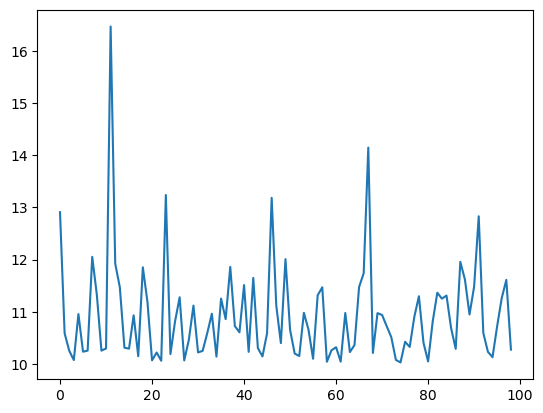

In [10]:
import scipy.stats as stats
foo = stats.expon(10.0)
stuff = list()
for i in range(1,100): 
    stuff.append(foo.rvs())
plt.plot(stuff)

In general, `stats.expon(0, m)` creates an exponential distribution with mean m, while stats.expon(n, m) creates an exponential distribution shifted by n with mean m. 

Read https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html and then run a randomized search over two random variables: C with an exponential distribution with mean 1 and shift 10.0 and gamma with an exponential distribution with mean 1 and shift .1. Put the result into `rgrid`. Tune the parameter `n_iter` of `RandomizedSearchCV` for a reasonable balance between tuning accuracy and performance. What's the best you can do by repeating this? Type that into the text box below. 

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon

start = time.process_time()
# BEGIN SOLUTION
param_dist = {
    'classify__C': expon(scale=1, loc=10.0),       # C with mean 1 and shifted by 10
    'classify__gamma': expon(scale=1, loc=0.1)     # gamma with mean 1 and shifted by 0.1
}

# Set up RandomizedSearchCV w/ pipeline and parameter dist.
rgrid = RandomizedSearchCV(pipe, param_dist, n_iter=100, cv=5, scoring='accuracy', random_state=42)

# Fit the randomized search to the iris dataset
rgrid.fit(iris.data, iris.target)

# END SOLUTION
# This printout is for my benefit
end = time.process_time()
print(end - start, "seconds computation time")
print(rgrid.best_params_)
print(rgrid.best_score_)

0.5338309999999922 seconds computation time
{'classify__C': 10.89750472130976, 'classify__gamma': 0.14756384975640854}
0.9800000000000001


I get {'classify__C': 11.806416850765888, 'classify__gamma': 0.14855628518704833}
with a score of 0.9800000000000001. For `n_iter` = 100, computation time is 1.7 seconds. 

In [13]:
assert isinstance(rgrid, sklearn.model_selection._search.RandomizedSearchCV)

Question 4: Consider the new pipeline: 

In [15]:
from sklearn.decomposition import PCA
p2 = Pipeline([['reduce', PCA(n_components=3)], ['scale', StandardScaler()], ['classify', SVC()]])

This does a dimension reduction from 4 dimensions to 3 before rescaling. Using the iris dataset, tune the hyper-parameters for the SVC step in this pipeline via any of the methods you've used (or any other, for that matter). What is the best you can do? What is the accuracy loss from reducing dimension from 4 to 3 dimensions before analysis? Answer these questions in the text box below. 

In [17]:
start = time.process_time()
# BEGIN SOLUTION

# Define the parameter distributions for the SVC hyperparameters
param_dist = {
    'classify__C': expon(scale=1, loc=10.0),       # C with mean 1 and shifted by 10
    'classify__gamma': expon(scale=1, loc=0.1)     # gamma with mean 1 and shifted by 0.1
}

# Set up RandomizedSearchCV with the new pipeline and parameter distributions
rgrid_pca = RandomizedSearchCV(p2, param_dist, n_iter=50, cv=5, scoring='accuracy', random_state=42)

# Fit the randomized search to the iris dataset
rgrid_pca.fit(iris.data, iris.target)

# END SOLUTION
# This printout is for my benefit
end = time.process_time()
print(end - start, "seconds computation time")
rgrid_pca.best_score_

0.36006500000000585 seconds computation time


0.9800000000000001